In [49]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import glob

import nibabel as nib
import cv2
import imageio
from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image

In [50]:
import fastai; fastai.__version__
from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

In [51]:
# Initialize an empty list to store file paths and names
file_list = []

# Traverse the first directory and get file paths and names
for dirname, _, filenames in os.walk('../input/liver-tumor-segmentation'):
    for filename in filenames:
        # Append tuple containing directory path and filename to the file_list
        file_list.append((dirname, filename))

# Traverse the second directory and get file paths and names
for dirname, _, filenames in os.walk('../input/liver-tumor-segmentation-part-2'):
    for filename in filenames:
        # Append tuple containing directory path and filename to the file_list
        file_list.append((dirname, filename))

# Create a DataFrame from the file_list with columns 'dirname' and 'filename'
df_files = pd.DataFrame(file_list, columns=['dirname', 'filename'])

# Sort the DataFrame by 'filename' column in ascending order
df_files.sort_values(by=['filename'], ascending=True, inplace=True)

In [52]:
# Initialize empty columns for mask directory and filename in the DataFrame
df_files["mask_dirname"] = ""
df_files["mask_filename"] = ""

# Loop through CT scan files (assuming there are 131 volumes)
for i in range(131):
    # Generate file names for CT scan and corresponding mask
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    
    # Update mask filename and directory for corresponding CT scan in the DataFrame
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "../input/liver-tumor-segmentation/segmentations"

# Create a new DataFrame containing rows with empty mask filenames (test data)
df_files_test = df_files[df_files.mask_filename=='']

# Remove rows with empty mask filenames from the original DataFrame and sort by filename
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True)

# Print the length of the updated DataFrame and display the DataFrame
print(len(df_files))
df_files

# Uncomment the line below if you want to see the DataFrame containing test data
# df_files_test


131


,dirname,filename,mask_dirname,mask_filename
0,../input/liver-tumor-segmentation/volume_pt1,volume-0.nii,../input/liver-tumor-segmentation/segmentations,segmentation-0.nii
1,../input/liver-tumor-segmentation/volume_pt1,volume-1.nii,../input/liver-tumor-segmentation/segmentations,segmentation-1.nii
2,../input/liver-tumor-segmentation/volume_pt1,volume-10.nii,../input/liver-tumor-segmentation/segmentations,segmentation-10.nii
3,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-100.nii,../input/liver-tumor-segmentation/segmentations,segmentation-100.nii
4,../input/liver-tumor-segmentation-part-2/volume_pt8,volume-101.nii,../input/liver-tumor-segmentation/segmentations,segmentation-101.nii
...,...,...,...,...
126,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-95.nii,../input/liver-tumor-segmentation/segmentations,segmentation-95.nii
127,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-96.nii,../input/liver-tumor-segmentation/segmentations,segmentation-96.nii
128,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-97.nii,../input/liver-tumor-segmentation/segmentations,segmentation-97.nii
129,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-98.nii,../input/liver-tumor-segmentation/segmentations,segmentation-98.nii


In [53]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    
    Parameters:
    filepath (str): Path to the .nii file
    
    Returns:
    array (numpy.ndarray): Pixel data from the .nii file as a NumPy array
    '''
    
    ct_scan = nib.load(filepath)  # Load the .nii file using nibabel
    array = ct_scan.get_fdata()  # Get the pixel data from the loaded .nii file
    array = np.rot90(np.array(array))  # Rotate the array 90 degrees counter-clockwise
    return array  # Return the rotated array containing pixel data

In [54]:
# Define a sample index to select a specific entry from the DataFrame
sample = 3

# Call the read_nii function to read the CT scan data from the specified file path in the DataFrame
sample_ct = read_nii(df_files.loc[sample, 'dirname'] + "/" + df_files.loc[sample, 'filename'])

# Call the read_nii function to read the corresponding mask data from the specified mask file path in the DataFrame
sample_mask = read_nii(df_files.loc[sample, 'mask_dirname'] + "/" + df_files.loc[sample, 'mask_filename'])

# Print the shape (dimensions) of the loaded CT scan and mask arrays to verify their sizes
print("CT Scan Shape:", sample_ct.shape)
print("Mask Shape:", sample_mask.shape)

# Print the full file path of the CT scan file for the selected sample
print("CT Scan File Path:", df_files.loc[sample, 'dirname'] + "/" + df_files.loc[sample, 'filename'])


CT Scan Shape: (512, 512, 685)
Mask Shape: (512, 512, 685)
CT Scan File Path: ../input/liver-tumor-segmentation-part-2/volume_pt6/volume-100.nii


In [55]:
# Print the minimum and maximum pixel values in the loaded CT scan array
print("Minimum Pixel Value in CT Scan:", np.amin(sample_ct))
print("Maximum Pixel Value in CT Scan:", np.amax(sample_ct))

# Print the minimum and maximum pixel values in the loaded mask array
print("Minimum Pixel Value in Mask:", np.amin(sample_mask))
print("Maximum Pixel Value in Mask:", np.amax(sample_mask))


Minimum Pixel Value in CT Scan: -1024.0
Maximum Pixel Value in CT Scan: 3071.0
Minimum Pixel Value in Mask: 0.0
Maximum Pixel Value in Mask: 2.0


In [56]:
# Define a namespace using types.SimpleNamespace to store different window settings for preprocessing NIfTI images
dicom_windows = types.SimpleNamespace(
    brain=(80, 40),         # Window settings for brain imaging
    subdural=(254, 100),     # Window settings for subdural imaging
    stroke=(8, 32),          # Window settings for stroke imaging
    brain_bone=(2800, 600),  # Window settings for imaging both brain and bone
    brain_soft=(375, 40),    # Window settings for soft brain tissue imaging
    lungs=(1500, -600),      # Window settings for lungs imaging
    mediastinum=(350, 50),   # Window settings for mediastinum imaging
    abdomen_soft=(400, 50),  # Window settings for soft abdomen tissue imaging
    liver=(150, 30),         # Window settings for liver imaging
    spine_soft=(250, 50),    # Window settings for soft spine tissue imaging
    spine_bone=(1800, 400),  # Window settings for imaging both spine and bone
    custom=(200, 60)         # Custom window settings
)

# Define a custom method 'windowed' using the @patch decorator to apply windowing to a Tensor (image data)
@patch
def windowed(self: Tensor, w, l):
    """
    Apply windowing to the image tensor.
    
    Parameters:
    - self (Tensor): Input image data as a PyTorch Tensor.
    - w (int): Window width, controlling the range of pixel values.
    - l (int): Window level, controlling the center of the window.
    
    Returns:
    - Tensor: Processed image data after applying windowing.
    """
    px = self.clone()  # Create a copy of the input tensor
    px_min = l - w // 2  # Calculate the minimum pixel value based on window width and level
    px_max = l + w // 2  # Calculate the maximum pixel value based on window width and level
    px[px < px_min] = px_min  # Clip pixel values below the minimum to the minimum value
    px[px > px_max] = px_max  # Clip pixel values above the maximum to the maximum value
    return (px - px_min) / (px_max - px_min)  # Normalize pixel values within the specified range


## Plot a image

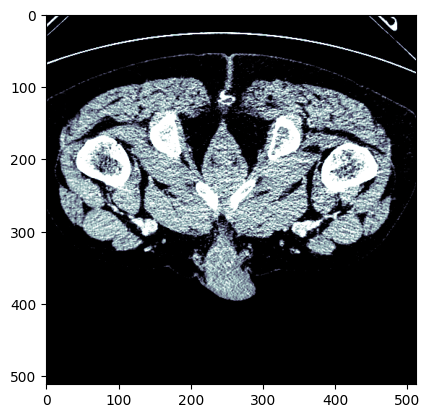

In [57]:
# Visualize a specific slice (index 50) from the CT scan data after applying windowing with liver-specific settings
# The 'tensor' function creates a PyTorch tensor from the selected slice of the CT scan data
# The 'windowed' method is applied to the tensor, using liver-specific window settings from the 'dicom_windows' namespace
# The resulting image is displayed using plt.imshow, with colormap set to 'bone' for better visualization
plt.imshow(
    tensor(sample_ct[..., 50].astype(np.float32)).windowed(*dicom_windows.liver),
    cmap=plt.cm.bone
)


In [58]:
def plot_sample(array_list, color_map='nipy_spectral'):
    '''
    Plots a slice with all available annotations
    
    Parameters:
    - array_list (list): List containing original image and corresponding mask (segmentation) data.
    - color_map (str): Colormap to be used for mask visualization. Default is 'nipy_spectral'.
    '''
    
    # Create a new figure for the plot with specified size
    fig = plt.figure(figsize=(18, 15))

    # Plot the original image in the first subplot
    plt.subplot(1, 4, 1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')  # Set subplot title for the original image

    # Plot the windowed image (after applying windowing) in the second subplot
    plt.subplot(1, 4, 2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone')
    plt.title('Windowed Image')  # Set subplot title for the windowed image

    # Plot the mask (segmentation) in the third subplot with specified colormap and transparency
    plt.subplot(1, 4, 3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')  # Set subplot title for the mask

    # Plot the original image overlaid with the mask in the fourth subplot
    plt.subplot(1, 4, 4)
    plt.imshow(array_list[0], cmap='bone')  # Plot the original image
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)  # Overlay the mask with specified colormap and transparency
    plt.title('Liver & Mask')  # Set subplot title for the original image overlaid with the mask

    # Display the plot with all subplots
    plt.show()


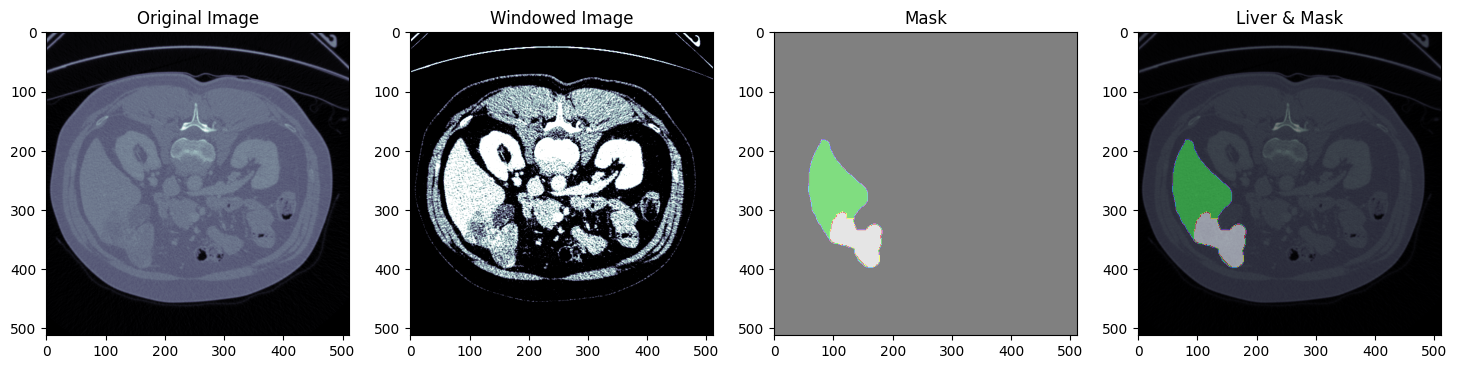

In [59]:
# Define the sample slice index to visualize
sample = 445

# Extract the specific slice from the CT scan data and mask data using the sample slice index
sample_slice = tensor(sample_ct[..., sample].astype(np.float32))  # Convert the slice to a PyTorch tensor

# Plot the sample slice along with its corresponding mask using the plot_sample function
# The function takes a list containing the original image slice and the corresponding mask slice
plot_sample([sample_ct[..., sample], sample_mask[..., sample]])

# Explanation:
# - 'sample' variable holds the index of the slice to be visualized.
# - 'sample_slice' is created by extracting the specific slice from the CT scan data, converted to a PyTorch tensor.
# - The 'plot_sample' function is called with a list containing the original image slice and the mask slice.
# - The function visualizes the original image, the windowed image, the mask, and the original image overlaid with the mask.


Mask Shape: (512, 512)
Unique Mask Pixel Values and Counts:
[[     0 248628]
 [     1   8902]
 [     2   4614]]


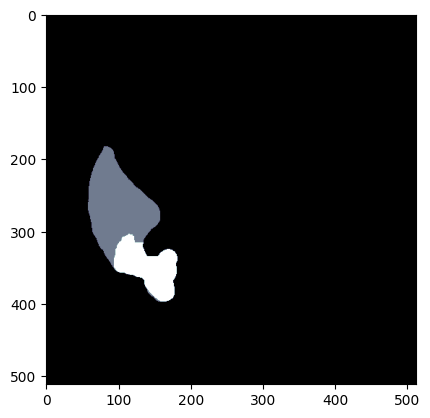

In [60]:
# Create an image from the mask slice, converting it to grayscale mode ('L') and unsigned 8-bit integer data type
mask = Image.fromarray(sample_mask[..., sample].astype('uint8'), mode="L")

# Print the shape of the mask image
print("Mask Shape:", mask.shape)

# Calculate and print the unique pixel values in the mask along with their respective counts
unique, counts = np.unique(mask, return_counts=True)
print("Unique Mask Pixel Values and Counts:")
print(np.array((unique, counts)).T)

# Display the mask image using plt.imshow, with colormap set to 'bone' for better visualization
plt.imshow(mask, cmap='bone')

# Explanation:
# - 'mask' variable holds the mask image created from the mask slice, converted to grayscale and uint8 data type.
# - The shape of the mask image is printed to provide information about its dimensions.
# - Unique pixel values and their respective counts in the mask are calculated, printed, and displayed for analysis.
# - The mask image is displayed using plt.imshow with a 'bone' colormap for visual inspection.


In [61]:
# Define a custom class `TensorCTScan` inheriting from `TensorImageBW` with specific show arguments for visualization
class TensorCTScan(TensorImageBW):
    _show_args = {'cmap': 'bone'}

# Define a patch function `freqhist_bins` to split the range of pixel values into groups with approximately equal pixel counts
@patch
def freqhist_bins(self: Tensor, n_bins=100):
    "A function to split the range of pixel values into groups, such that each group has around the same number of pixels"
    imsd = self.view(-1).sort()[0]  # Flatten the tensor and sort the pixel values in ascending order
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float() / n_bins + (1 / (2 * n_bins)),
                   tensor([0.999])])
    t = (len(imsd) * t).long()
    return imsd[t].unique()  # Return unique pixel values representing bins for histogram equalization

# Define a patch function `hist_scaled` to scale the tensor using histogram equalization to values between 0 and 1
@patch
def hist_scaled(self: Tensor, brks=None):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if self.device.type == 'cuda':
        return self.hist_scaled_pt(brks)
    if brks is None:
        brks = self.freqhist_bins()  # Calculate histogram bins using `freqhist_bins` function
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)  # Interpolate pixel values based on histogram bins
    return tensor(x).reshape(self.shape).clamp(0., 1.)  # Reshape and clamp values between 0 and 1

# Define a patch function `to_nchan` to create a multi-channel tensor with windowed and histogram equalized channels
@patch
def to_nchan(x: Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]  # Apply windowing to create channels based on specified window settings
    if not isinstance(bins, int) or bins != 0:
        res.append(x.hist_scaled(bins).clamp(0, 1))  # Apply histogram equalization as an additional channel if bins are provided
    dim = [0, 1][x.dim() == 3]  # Determine the dimension to stack channels based on tensor shape
    return TensorCTScan(torch.stack(res, dim=dim))  # Return multi-channel tensor with windowed and histogram equalized channels

# Define a patch function `save_jpg` to save the multi-channel tensor as a JPEG image
@patch
def save_jpg(x: Tensor, path, wins, bins=None, quality=90):
    fn = Path(path).with_suffix('.jpg')  # Create a file path with .jpg extension
    x = (x.to_nchan(wins, bins) * 255).byte()  # Scale tensor values to 0-255 range for image representation
    im = Image.fromarray(x.permute(1, 2, 0).numpy(), mode=['RGB', 'CMYK'][x.shape[0] == 4])  # Create image from tensor data
    im.save(fn, quality=quality)  # Save the image as a JPEG file with specified quality

# Explanation:
# - `TensorCTScan` is a custom class inheriting from `TensorImageBW` with specific show arguments for visualization.
# - `freqhist_bins` calculates histogram bins for equalizing pixel values.
# - `hist_scaled` performs histogram equalization on the tensor.
# - `to_nchan` creates a multi-channel tensor with windowed and histogram equalized channels.
# - `save_jpg` saves the multi-channel tensor as a JPEG image with specified quality.


## Test plot

In [62]:
'''
_,axs=subplots(1,1)

sample_slice.save_jpg('test.jpg', [dicom_windows.liver,dicom_windows.custom])
show_image(Image.open('test.jpg'), ax=axs[0])
show_image(Image.open('test.png'), ax=axs[0])

'''


"\n_,axs=subplots(1,1)\n\nsample_slice.save_jpg('test.jpg', [dicom_windows.liver,dicom_windows.custom])\nshow_image(Image.open('test.jpg'), ax=axs[0])\nshow_image(Image.open('test.png'), ax=axs[0])\n\n"

In [63]:
# df_files=df_files[100:131]
df_files=df_files[100:111]
df_files


# df_files=df_files[0:100]
# df_files

# test = df_files[101:130]

,dirname,filename,mask_dirname,mask_filename
100,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-71.nii,../input/liver-tumor-segmentation/segmentations,segmentation-71.nii
101,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-72.nii,../input/liver-tumor-segmentation/segmentations,segmentation-72.nii
102,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-73.nii,../input/liver-tumor-segmentation/segmentations,segmentation-73.nii
103,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-74.nii,../input/liver-tumor-segmentation/segmentations,segmentation-74.nii
104,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-75.nii,../input/liver-tumor-segmentation/segmentations,segmentation-75.nii
105,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-76.nii,../input/liver-tumor-segmentation/segmentations,segmentation-76.nii
106,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-77.nii,../input/liver-tumor-segmentation/segmentations,segmentation-77.nii
107,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-78.nii,../input/liver-tumor-segmentation/segmentations,segmentation-78.nii
108,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-79.nii,../input/liver-tumor-segmentation/segmentations,segmentation-79.nii
109,../input/liver-tumor-segmentation/volume_pt1,volume-8.nii,../input/liver-tumor-segmentation/segmentations,segmentation-8.nii


In [64]:
# Make custom JPG files for Unet training
# Total number of 131 nii files contains 67072 slices 

GENERATE_JPG_FILES = True   # warning: generation takes ~ 1h
slice_sum=0
if (GENERATE_JPG_FILES):
    
    path = Path(".")

    os.makedirs('train_images',exist_ok=True)
    os.makedirs('train_masks',exist_ok=True)

    for ii in tqdm(range(100+0,100+len(df_files))): # take 1/3 nii files for training
        curr_ct        = read_nii(df_files.loc[ii,'dirname']+"/"+df_files.loc[ii,'filename'])
        curr_mask      = read_nii(df_files.loc[ii,'mask_dirname']+"/"+df_files.loc[ii,'mask_filename'])
        curr_file_name = str(df_files.loc[ii,'filename']).split('.')[0]
        curr_dim       = curr_ct.shape[2] # 512, 512, curr_dim
        slice_sum = slice_sum+curr_dim
        
        for curr_slice in range(0,curr_dim,1): # export every 2nd slice for training
            data = tensor(curr_ct[...,curr_slice].astype(np.float32))
            mask = Image.fromarray(curr_mask[...,curr_slice].astype('uint8'), mode="L")
            data.save_jpg(f"train_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver,dicom_windows.custom])
            mask.save(f"train_masks/{curr_file_name}_slice_{curr_slice}_mask.png")
            
else:
    
    path = Path("../input/liver-segmentation-with-fastai-v2") # read jpg from saved kernel output
print(slice_sum)

  0%|          | 0/11 [00:00<?, ?it/s]

1869


In [64]:
# !rm -rf ./train_images
# !rm -rf ./train_masks

# MODEL TRAINING

In [65]:
import numpy as np

In [66]:
# Define batch size and image size for data processing
bs = 16  # Batch size
im_size = 128  # Image size (both width and height)

# Define class labels for semantic segmentation (background, liver, tumor)
codes = np.array(["background", "liver", "tumor"])

# Define a function to get the input (image) file path given a file name
def get_x(fname: Path):
    return fname

# Define a function to get the corresponding label (mask) file path given an input file path
def label_func(x):
    return path / 'train_masks' / f'{x.stem}_mask.png'

# Define transformations for data processing (integer to float tensor conversion and normalization)
tfms = [IntToFloatTensor(), Normalize()]

# Define a data block for loading and processing image and mask data
db = DataBlock(
    blocks=(ImageBlock(), MaskBlock(codes)),  # Define image and mask blocks with class codes
    batch_tfms=tfms,  # Apply batch-level transformations
    splitter=RandomSplitter(),  # Use random splitter for train-validation split
    item_tfms=[Resize(im_size)],  # Resize input images to the specified image size
    get_items=get_image_files,  # Function to get input image files
    get_y=label_func  # Function to get corresponding mask files (labels)
)

# Define the data source (input directory containing images) and create datasets using the data block
# Note: Ensure that the correct path to the input images is provided in the 'source' parameter.
ds = db.datasets(source='./train_images')

# Print the total number of items (samples) in the dataset and the dataset information
print("Total Number of Items in the Dataset:", len(ds))
print("Dataset Information:", ds)

# Explanation:
# - `bs` specifies the batch size used during training.
# - `im_size` defines the target image size after resizing.
# - `codes` contains class labels for semantic segmentation (background, liver, tumor).
# - `get_x` and `label_func` functions define how to get input and label file paths, respectively.
# - `tfms` contains transformations such as integer to float tensor conversion and normalization.
# - `db` is a DataBlock object that defines how to load, transform, and split the data.
# - `ds` is created by applying the data block to the specified source directory containing images.
# - The printed information provides details about the total number of items (samples) in the dataset and the dataset structure.


Total Number of Items in the Dataset: 1869
Dataset Information: (#1869) [(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512),(PILImage mode=RGB size=512x512, PILMask mode=L size=512x512)...]


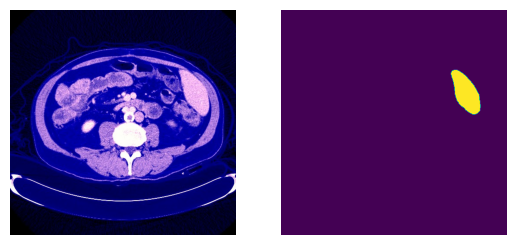

In [67]:
# Define the index of the dataset item to visualize
idx = 20

# Retrieve input image and corresponding mask from the dataset using the specified index
imgs = [ds[idx][0], ds[idx][1]]

# Create a subplot with 1 row and 2 columns to display the input image and mask side by side
fig, axs = plt.subplots(1, 2)

# Iterate over the subplots and configure their properties
for i, ax in enumerate(axs.flatten()):
    ax.axis('off')  # Turn off axis for cleaner visualization
    ax.imshow(imgs[i])  # Display the current image (input image or mask) on the subplot

# Explanation:
# - `idx` specifies the index of the dataset item to visualize.
# - `ds[idx][0]` retrieves the input image from the dataset at the specified index.
# - `ds[idx][1]` retrieves the corresponding mask from the dataset at the specified index.
# - `fig, axs = plt.subplots(1, 2)` creates a subplot with 1 row and 2 columns for displaying two images side by side.
# - The loop iterates over the subplots and configures their properties, turning off the axis and displaying the images.
# - The input image and mask are displayed side by side for visual inspection


In [68]:
# Retrieve the mask data from the dataset at the specified index (`idx`)
mask_data = ds[idx][1]

# Calculate the unique pixel values in the mask and their respective counts
unique, counts = np.unique(mask_data, return_counts=True)

# Print the unique pixel values and their corresponding counts
print("Unique Pixel Values and Counts in Mask:")
print(np.array((unique, counts)).T)

# Explanation:
# - `mask_data` contains the mask data retrieved from the dataset at the specified index (`idx`).
# - `np.unique(mask_data, return_counts=True)` calculates unique pixel values in the mask and their counts.
# - `unique` stores the unique pixel values, and `counts` stores the corresponding counts.
# - `np.array((unique, counts)).T` creates a transposed array pairing unique values with their counts.
# - The printed output displays the unique pixel values in the mask and their respective counts for analysis.
# - This information provides insights into the distribution of pixel values in the mask.


Unique Pixel Values and Counts in Mask:
[[     0 258068]
 [     1   4076]]


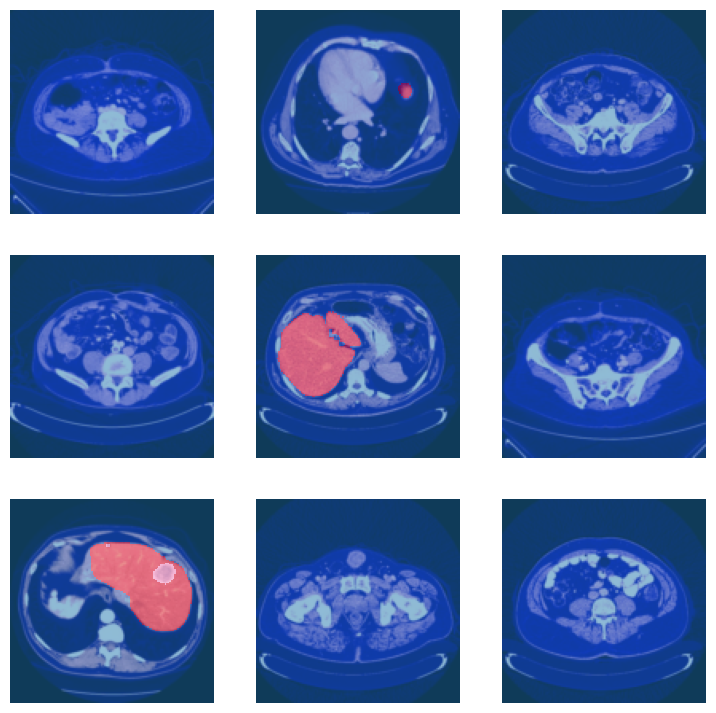

In [69]:
# Create dataloaders for training and validation data using the defined data block (`db`)
# `path/'train_images'` specifies the directory containing training images, and `bs` is the batch size
dls = db.dataloaders(path/'train_images', bs=bs)  # `num_workers=0` can be added for parallel processing

# Show a batch of data to inspect how the images and masks are loaded and processed
dls.show_batch()

# Explanation:
# - `db.dataloaders(path/'train_images', bs=bs)` creates dataloaders for training and validation data.
# - `path/'train_images'` specifies the directory containing the training images.
# - `bs` is the batch size used during training and validation.
# - `num_workers=0` (optional) can be added to specify the number of worker processes for data loading (parallel processing).
# - `dls.show_batch()` displays a batch of data from the dataloaders for visual inspection.
# - The function shows how images and masks are loaded, transformed, and batched for training the UNet model.


In [70]:
# Define a function to compute non-background accuracy for multiclass segmentation
# Exclude a specified background index (`bkg_idx`) from the metric calculation
def foreground_acc(inp, targ, bkg_idx=0, axis=1):
    """
    Computes non-background accuracy for multiclass segmentation.

    Parameters:
        - inp (Tensor): Predicted tensor from the model (logits).
        - targ (Tensor): Target tensor with true labels.
        - bkg_idx (int): Index of the background class to be excluded (default is 0).
        - axis (int): Axis along which to compute the accuracy (default is 1).

    Returns:
        - float: Accuracy of non-background classes.
    """
    targ = targ.squeeze(1)  # Remove the channel dimension from the target tensor
    mask = targ != bkg_idx  # Create a mask excluding the specified background index
    return (inp.argmax(dim=axis)[mask] == targ[mask]).float().mean()

# Define a custom accuracy function that includes the background class in the metric calculation
def cust_foreground_acc(inp, targ):
    """
    Computes accuracy for multiclass segmentation, including the background class.

    Parameters:
        - inp (Tensor): Predicted tensor from the model (logits).
        - targ (Tensor): Target tensor with true labels.

    Returns:
        - float: Accuracy of all classes including the background.
    """
    # Call the foreground_acc function with a dummy background index (3) to include the background class
    return foreground_acc(inp=inp, targ=targ, bkg_idx=3, axis=1)

# Explanation:
# - `foreground_acc` computes accuracy excluding a specified background index (`bkg_idx`) in the segmentation task.
# - `inp` is the predicted tensor from the model, and `targ` is the target tensor with true labels.
# - The function calculates accuracy for non-background classes along the specified axis (default is axis 1).
# - `cust_foreground_acc` is a custom accuracy function that includes the background class in the metric calculation.
# - It calls `foreground_acc` with a dummy background index (3) to include the background class in the accuracy metric.
# - These functions are useful for evaluating segmentation model performance, especially in cases with background classes.


In [71]:
# Create a UNet learner for semantic segmentation using the specified data loaders (`dls`),
# a ResNet-34 backbone, and the CrossEntropyLossFlat loss function with class axis 1.
# Include custom metrics: `foreground_acc` (excludes specified background class) and `cust_foreground_acc` (includes background class).
learn = unet_learner(dls, resnet34, loss_func=CrossEntropyLossFlat(axis=1), metrics=[foreground_acc, cust_foreground_acc])

# Explanation:
# - `unet_learner` creates a learner object for semantic segmentation tasks using a UNet architecture.
# - `dls` is the data loaders object containing training and validation data.
# - `resnet34` specifies the ResNet-34 backbone architecture for the UNet model.
# - `CrossEntropyLossFlat(axis=1)` is used as the loss function for multi-class segmentation.
#   - `axis=1` indicates that the class axis is 1 in the target tensor.
# - `metrics` parameter specifies the evaluation metrics used during training.
# - `foreground_acc` calculates accuracy excluding a specified background class.
# - `cust_foreground_acc` calculates accuracy including the background class.
# - These metrics provide insights into model performance for both foreground and background classes.
# - The `learn` object encapsulates the model, data, loss function, and evaluation metrics for training and validation.


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=9.120108734350652e-05)

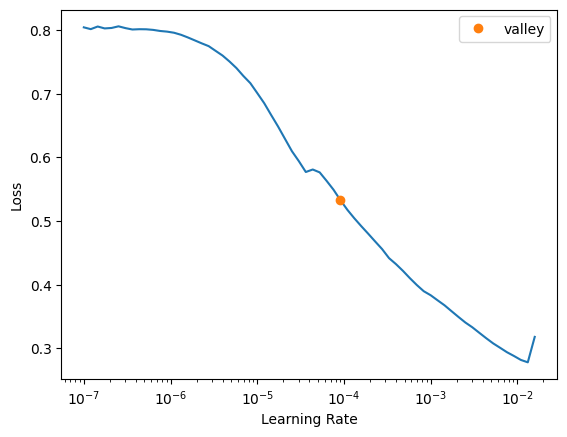

In [72]:
# Find an optimal learning rate using the learning rate finder method
learn.lr_find()

# Explanation:
# - `learn.lr_find()` is a fastai method that helps find an appropriate learning rate for training the model.
# - During the execution of this method, the model is trained with a range of learning rates and the loss is recorded.
# - A plot is generated showing the loss values for different learning rates.
# - The purpose is to identify a learning rate where the loss is decreasing quickly without diverging or plateauing.
# - This step is essential for selecting an appropriate learning rate before training the model to ensure effective training.


In [73]:
# Fine-tune the pre-trained model for a specified number of epochs (5 in this case)
# Apply weight decay (L2 regularization) with a weight decay factor of 0.1
# Use the SaveModelCallback to save the model with the best validation performance
learn.fine_tune(5, wd=0.1, cbs=SaveModelCallback())

# Explanation:
# - `learn.fine_tune()` is a fastai method that fine-tunes a pre-trained model on the training data.
# - The first argument (5 in this case) specifies the number of epochs for fine-tuning the model.
# - `wd=0.1` specifies the weight decay (L2 regularization) factor applied during training to prevent overfitting.
# - `cbs=SaveModelCallback()` specifies the use of the SaveModelCallback callback during training.
# - The SaveModelCallback callback saves the model with the best validation performance based on a specified metric.
# - Fine-tuning involves training the model's final layers on the specific dataset to improve task-specific performance.
# - Weight decay helps in regularization, preventing the model from memorizing the training data and improving generalization.
# - The callback saves the model checkpoint with the best validation performance, allowing model reusability.
# - After fine-tuning, the model will be trained for the specified number of epochs and saved using the SaveModelCallback.


epoch,train_loss,valid_loss,foreground_acc,cust_foreground_acc,time
0,0.034915,0.023655,0.793879,0.992357,00:14


Better model found at epoch 0 with valid_loss value: 0.023655273020267487.


epoch,train_loss,valid_loss,foreground_acc,cust_foreground_acc,time
0,0.009591,0.007338,0.913566,0.997228,00:15
1,0.010331,0.008754,0.898446,0.996831,00:15
2,0.006605,0.005733,0.936361,0.997771,00:15
3,0.004630,0.004467,0.954220,0.998248,00:14
4,0.003664,0.004307,0.957359,0.998307,00:15


Better model found at epoch 0 with valid_loss value: 0.007338156457990408.
Better model found at epoch 2 with valid_loss value: 0.005733219441026449.
Better model found at epoch 3 with valid_loss value: 0.004467006307095289.
Better model found at epoch 4 with valid_loss value: 0.0043072388507425785.


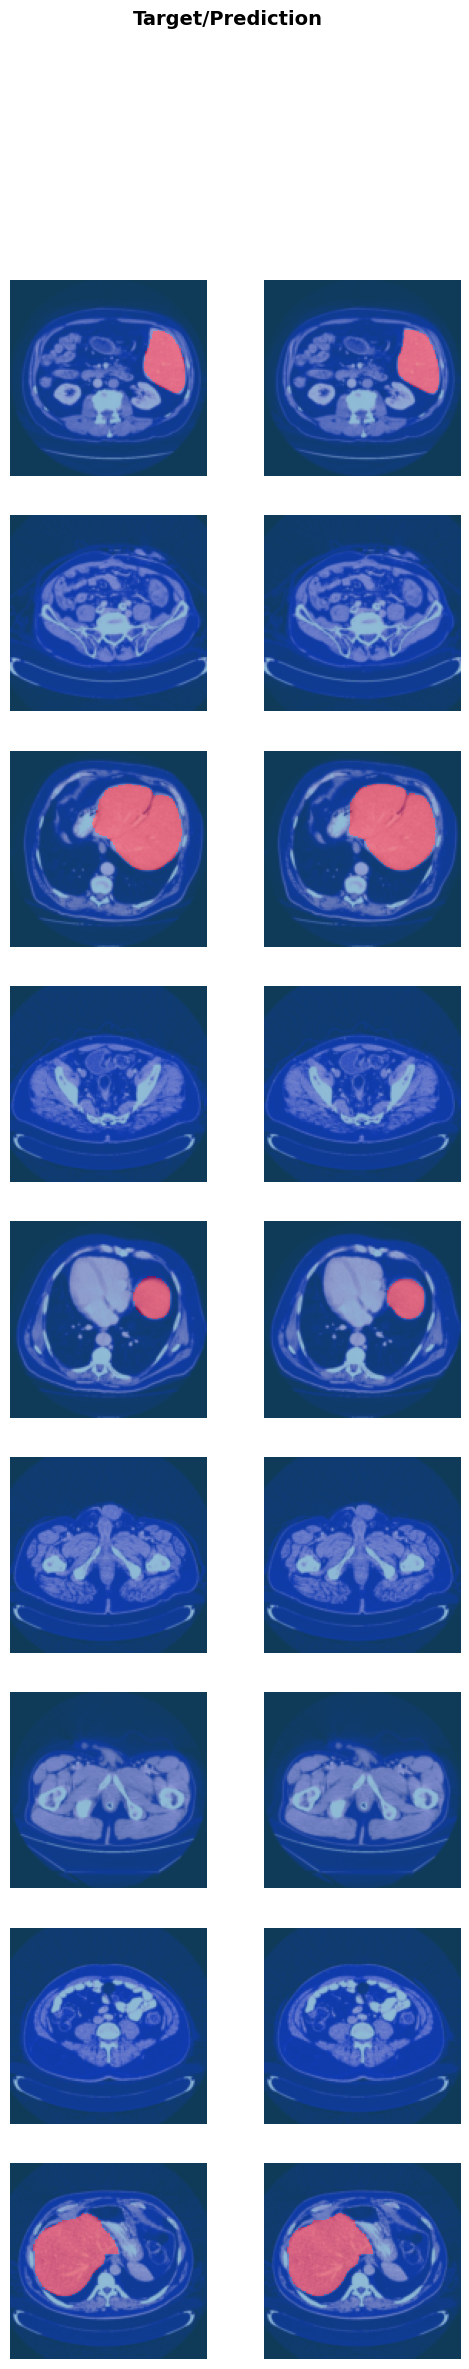

In [74]:
# Visualize the model's predictions and ground truth masks for a batch of validation data
learn.show_results()

# Explanation:
# - `learn.show_results()` is a fastai method that visualizes the model's predictions and ground truth masks.
# - This method displays a grid of images containing input images, model predictions, and corresponding ground truth masks.
# - It provides a qualitative evaluation of the model's performance on a batch of validation data.
# - The purpose is to visually assess how well the model is segmenting objects of interest in the input images.



In [75]:
# Save the trained model for later use or deployment
learn.export(path / 'Liver_segmentation')

# Explanation:
# - `learn.export()` is a method provided by fastai to save the trained model's architecture, weights, and necessary information.
# - `path / 'Liver_segmentation'` specifies the path and filename for saving the exported model.
# - The exported model can be loaded and used for inference without retraining, making it convenient for future predictions.
# - Saving the model allows for reuse in various applications, such as medical image analysis, without the need to train it again.
# - Ensure that the specified path exists and has appropriate write permissions to successfully save the exported model.


In [76]:
import gc
del learn
gc.collect()
torch.cuda.empty_cache()

# TESTING MODEL

### Run this cell to do the required imports

In [77]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import glob

import nibabel as nib
import cv2
import imageio
from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image


import fastai; 
print(fastai.__version__)
from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

2.7.12


#### Run this cell to make sure the data files are loaded into a variable called as `df_files` (it has to a pandas dataframe) This cell also defines the function required for nii file format conversion

In [78]:
# Create a meta file containing information about NII files for liver tumor segmentation

# Initialize an empty list to store file paths and filenames
file_list = []

# Iterate through directories and filenames in the first dataset directory
for dirname, _, filenames in os.walk('../input/liver-tumor-segmentation'):
    for filename in filenames:
        file_list.append((dirname, filename))  # Add directory and filename to the file list

# Iterate through directories and filenames in the second dataset directory
for dirname, _, filenames in os.walk('../input/liver-tumor-segmentation-part-2'):
    for filename in filenames:
        file_list.append((dirname, filename))  # Add directory and filename to the file list

# Create a DataFrame from the collected file paths and filenames
df_files = pd.DataFrame(file_list, columns=['dirname', 'filename'])

# Initialize mask directory and mask filename columns in the DataFrame
df_files["mask_dirname"] = ""
df_files["mask_filename"] = ""

# Map CT scan filenames to corresponding mask filenames
for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    
    # Update mask directory and mask filename for rows corresponding to CT scan filenames
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "../input/liver-tumor-segmentation/segmentations"

# Create a test DataFrame containing rows with empty mask filenames
df_files_test = df_files[df_files.mask_filename == '']

# Drop rows with empty mask filenames from the main DataFrame and sort it based on filenames
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True)

# Print the number of rows in the processed DataFrame
print(len(df_files))

# Define a function to read NII files and convert them into numpy arrays
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    # Load the NII file using nibabel and get the pixel array
    ct_scan = nib.load(filepath)
    array = ct_scan.get_fdata()
    
    # Rotate the array 90 degrees for proper orientation
    array = np.rot90(np.array(array))
    return array

# Explanation:
# - The code collects file paths and filenames from two dataset directories and creates a DataFrame `df_files`.
# - The DataFrame contains columns for directory names, filenames, mask directory names, and mask filenames.
# - Rows with empty mask filenames are separated into a test DataFrame `df_files_test`.
# - The main DataFrame `df_files` is processed to drop rows with empty mask filenames and sort it based on filenames.
# - The `read_nii` function is defined to read NII files and convert them into numpy arrays for further processing.

131


### Split the dataset into test and train. This assumes that the same split was used for training the model and the model has not seen the test datas

In [79]:
# df_files=df_files[100:131]
# df_files

# first 20 data points
df_file = df_files[0:20]

### Below cell imports the trained model and also defines a few variables and functions required for the tetsing.
**Make sure you define the path as per your system**

Definning things required for loading the model

In [80]:
# Load saved model
bs = 16
im_size = 128

# the labels used for the classes
# When predicting the model predicts it in terms of indices (ie 0 --> background, 1 --> liver ...)
codes = np.array(["background","liver","tumor"])

# the default pathb
path = './'

def get_x(fname:Path): 
    return fname

def label_func(x): 
    return path/'train_masks'/f'{x.stem}_mask.png'

def foreground_acc(inp, targ, bkg_idx=0, axis=1):  # exclude a background from metric
    "Computes non-background accuracy for multiclass segmentation"
    targ = targ.squeeze(1)
    mask = targ != bkg_idx
    return (inp.argmax(dim=axis)[mask]==targ[mask]).float().mean() 

def cust_foreground_acc(inp, targ):  # # include a background into the metric
    return foreground_acc(inp=inp, targ=targ, bkg_idx=3, axis=1) # 3 is a dummy value to include the background which is 0

## Loading the model

In [84]:
# Define image transformations for preprocessing
tfms = [Resize(im_size), IntToFloatTensor(), Normalize()]

# Load the trained Fastai model from the specified path
# 'Liver_segmentation' is the exported model filename saved in the 'working' directory
# Set `cpu=False` to load the model on GPU if available, enabling faster inference
learn0 = load_learner('../working/Liver_segmentation', cpu=False)

# Apply the defined image transformations to the loaded learner's data loaders
learn0.dls.transform = tfms

# Explanation:
# - `tfms` defines a list of image transformations, including resizing, normalization, and conversion to float tensor.
# - `Resize(im_size)` resizes the images to a specified size (`im_size`), ensuring consistent input dimensions.
# - `IntToFloatTensor()` converts integer image tensors to float tensors for numerical stability during processing.
# - `Normalize()` normalizes pixel values to a standard range, enhancing model performance and convergence.
# - `load_learner('../working/Liver_segmentation', cpu=False)` loads the trained Fastai learner from the specified path.
# - The exported model file ('Liver_segmentation') contains the model's architecture, weights, and necessary information.
# - `cpu=False` allows the model to be loaded on GPU if available, enabling faster inference for large-scale data.
# - After loading the model, the defined image transformations (`tfms`) are applied to the learner's data loaders.

### Convert the nii file to the format used by the model. So that prediction is possible

In [85]:
# Define a function to transform a single NII file into a list of TensorImages
# The transformation includes windowing and converting the data into TensorImages

def nii_tfm(fn, wins):
    """
    Transform a single NII file into a list of TensorImages.

    Parameters:
        - fn (str): Filepath of the NII file to be transformed.
        - wins (tuple): Windowing parameters specified as (width, level).

    Returns:
        - list: A list containing TensorImages transformed from the NII file slices.
    """
    # Read the NII file and obtain its pixel array
    test_nii = read_nii(fn)
    
    # Get the number of slices in the NII file
    curr_dim = test_nii.shape[2]
    
    # Initialize an empty list to store transformed slices as TensorImages
    slices = []
    
    # Iterate through specific slices in the NII file and transform them
    # For example, the slice at index 450 is processed in this case
    data = tensor(test_nii[..., 450].astype(np.float32))  # Extract a specific slice from the NII data
    data = (data.to_nchan(wins) * 255).byte()  # Apply windowing and scale pixel values to [0, 255]
    slices.append(TensorImage(data))  # Add the transformed slice as a TensorImage to the list
    
    # Print the list of transformed slices (optional, can be used for debugging)
    print(slices)
    
    # Return the list containing TensorImages transformed from specific slices of the NII file
    return slices

# Explanation:
# - `nii_tfm` is a function that takes a filepath (`fn`) and windowing parameters (`wins`) as inputs.
# - The function reads the NII file, extracts a specific slice (e.g., index 450), and transforms it into a TensorImage.
# - The windowing parameters (`wins`) control the contrast and brightness of the image data.
# - The transformed slice is added to the `slices` list, which is returned as a list of TensorImages.

## Prediction Demonstration : test number and slice number are arbitrary

(512, 512, 685)


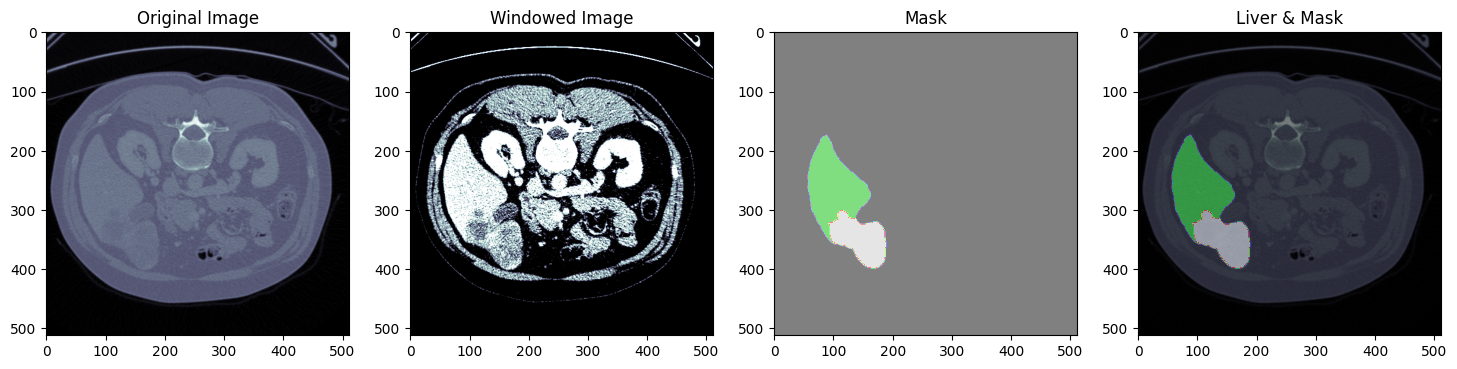

In [86]:
# Define the test number and specific slice index for visualization
tst = 3  # Test number (index) in the DataFrame
test_slice_idx = 450  # Specific slice index to be visualized

# Read the NII files corresponding to the test number from the DataFrame
test_nii = read_nii(df_files.loc[tst, 'dirname'] + "/" + df_files.loc[tst, 'filename'])
test_mask = read_nii(df_files.loc[tst, 'mask_dirname'] + "/" + df_files.loc[tst, 'mask_filename'])

# Print the shape of the loaded NII data for informational purposes
print(test_nii.shape)

# Extract the specific slice from the NII data for visualization
sample_slice = tensor(test_nii[..., test_slice_idx].astype(np.float32))

# Plot the original image and corresponding mask (segmentation) for the specific slice
plot_sample([test_nii[..., test_slice_idx], test_mask[..., test_slice_idx]])

# Explanation:
# - `tst` specifies the index of the test sample (row) in the DataFrame `df_files` that will be visualized.
# - `test_slice_idx` specifies the index of the specific slice from the NII data to be visualized.
# - The NII files corresponding to the test number are loaded into `test_nii` (CT scan) and `test_mask` (segmentation mask).
# - The shape of the loaded NII data is printed to provide information about the dimensions of the CT scan volume.
# - `sample_slice` extracts the specific slice from the CT scan data for visualization purposes.
# - The `plot_sample` function is called to visualize the original image and its corresponding mask for the specified slice.


In [87]:
# Prepare a test NII file for prediction using the defined transformation function

# Call the 'nii_tfm' function to transform the test NII file into a list of TensorImages
# Pass the file path and windowing parameters as arguments to the 'nii_tfm' function
test_files = nii_tfm(df_files.loc[tst, 'dirname'] + "/" + df_files.loc[tst, 'filename'], [dicom_windows.liver, dicom_windows.custom])

# Print the number of transformed slices in the test NII file for prediction
print("Number of test slices: ", len(test_files))

# Explanation:
# - `df_files.loc[tst, 'dirname'] + "/" + df_files.loc[tst, 'filename']` constructs the full file path for the test NII file.
# - The 'nii_tfm' function is called to transform the test NII file into a list of TensorImages.
# - Windowing parameters (`dicom_windows.liver` and `dicom_windows.custom`) control the contrast and brightness of the images.
# - The transformed slices are stored in the `test_files` list for prediction.
# - The number of transformed slices is printed to provide information about the size of the test data.

[TensorImage([[[ 0,  0,  0,  ...,  0,  0,  0],
              [ 0,  0,  0,  ...,  0,  0,  0],
              [ 0,  0,  0,  ...,  0,  0,  0],
              ...,
              [ 0,  0,  0,  ...,  0,  0,  0],
              [ 0,  0,  0,  ...,  0,  0,  0],
              [ 0,  0,  0,  ...,  0,  0,  0]],

             [[ 0,  0,  0,  ...,  0,  0,  0],
              [ 0,  0,  0,  ...,  0,  0,  0],
              [ 0,  0,  0,  ...,  0,  0,  0],
              ...,
              [ 0,  0,  0,  ...,  0,  0,  0],
              [ 0,  0,  0,  ...,  0,  0,  0],
              [ 0,  0,  0,  ...,  0,  0,  0]],

             [[29, 52, 68,  ..., 47, 24, 23],
              [18, 35, 70,  ..., 19, 13, 26],
              [52, 23, 41,  ..., 18, 19, 15],
              ...,
              [ 0,  0,  0,  ...,  0,  0,  0],
              [ 0,  0,  0,  ...,  0,  0,  0],
              [ 0,  0,  0,  ...,  0,  0,  0]]], dtype=torch.uint8)]
Number of test slices:  1


<Axes: >

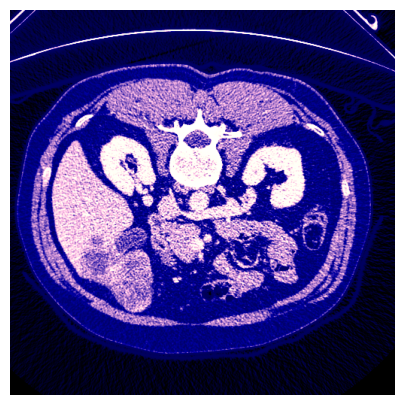

In [88]:
# Display a transformed slice from the prepared test NII file for inspection

# Use the 'show_image' function from Fastai to display the first transformed slice from the test NII file
show_image(test_files[0])



<class 'fastai.torch_core.TensorBase'>


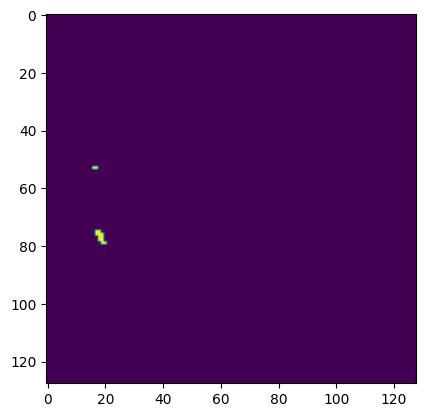

In [91]:
# Get predictions for the prepared test file using the trained model

# Create a test dataloader using the transformed test data and the loaded learner's dataloader configuration
test_dl = learn0.dls.test_dl(test_files)

# Get predictions and true labels from the test dataloader using the 'get_preds' method
preds, y = learn0.get_preds(dl=test_dl)

# Extract the predicted segmentation mask by selecting the class index with the highest probability
predicted_mask = np.argmax(preds, axis=1)

# Print the data type of the predicted mask for informational purposes
print(type(predicted_mask))

# Display the first predicted segmentation mask as an image for visualization
plt.imshow(predicted_mask[0])

In [93]:
# Convert the first predicted segmentation mask to a NumPy array
a = np.array(predicted_mask[0])

# Calculate unique values and their respective counts in the predicted mask
unique, counts = np.unique(a, return_counts=True)

# Print the unique values and their counts in the predicted mask
print(np.array((unique, counts)).T)

# Calculate and print the minimum and maximum values in the predicted mask
min_value = np.amin(a)  # Calculate the minimum value in the predicted mask
max_value = np.amax(a)  # Calculate the maximum value in the predicted mask
print(min_value, max_value)


[[    0 16371]
 [    1    13]]
0 1


### Predictions for multiple images.

  0%|          | 0/30 [00:00<?, ?it/s]

curr slice: 250
predicted [0]
actual: [0]


curr slice: 260
predicted [0]
actual: [0]


curr slice: 270
predicted [0]
actual: [0]


curr slice: 280
predicted [0]
actual: [0]


curr slice: 290
predicted [0]
actual: [0]


curr slice: 300
predicted [0]
actual: [0]


curr slice: 310
predicted [0]
actual: [0]


curr slice: 320
predicted [0]
actual: [0]


curr slice: 330
predicted [0]
actual: [0]


curr slice: 340
predicted [0]
actual: [0]


curr slice: 350
predicted [0]
actual: [0]


curr slice: 360
predicted [0]
actual: [0]


curr slice: 370
predicted [0]
actual: [0]


curr slice: 380
predicted [0]
actual: [0]


curr slice: 390
predicted [0]
actual: [0 1]


curr slice: 400
predicted [0]
actual: [0 1]


curr slice: 410
predicted [0]
actual: [0 1 2]


curr slice: 420
predicted [0]
actual: [0 1 2]


curr slice: 430
predicted [0]
actual: [0 1 2]


curr slice: 440
predicted [0 1]
actual: [0 1 2]


curr slice: 450
predicted [0 1]
actual: [0 1 2]


curr slice: 460
predicted [0 1]
actual: [0 1 2]


curr slice: 470
predicted [0 1]
actual: [0 1 2]


curr slice: 480
predicted [0 1]
actual: [0 1 2]


curr slice: 490
predicted [0]
actual: [0 1 2]


curr slice: 500
predicted [0 1]
actual: [0 1 2]


curr slice: 510
predicted [0 1 2]
actual: [0 1 2]


curr slice: 520
predicted [0 1 2]
actual: [0 1 2]


curr slice: 530
predicted [0 1 2]
actual: [0 1 2]


curr slice: 540
predicted [0 1 2]
actual: [0 1 2]


  0%|          | 0/30 [00:00<?, ?it/s]

curr slice: 250
predicted [0]
actual: [0]


curr slice: 260
predicted [0]
actual: [0]


curr slice: 270
predicted [0]
actual: [0]


curr slice: 280
predicted [0 1]
actual: [0]


curr slice: 290
predicted [0]
actual: [0]


curr slice: 300
predicted [0]
actual: [0]


curr slice: 310
predicted [0 1]
actual: [0]


curr slice: 320
predicted [0 1]
actual: [0]


curr slice: 330
predicted [0 1]
actual: [0]


curr slice: 340
predicted [0 1]
actual: [0]


curr slice: 350
predicted [0]
actual: [0]


curr slice: 360
predicted [0 1]
actual: [0]


curr slice: 370
predicted [0]
actual: [0]


curr slice: 380
predicted [0]
actual: [0]


curr slice: 390
predicted [0]
actual: [0 1]


curr slice: 400
predicted [0]
actual: [0 1]


curr slice: 410
predicted [0]
actual: [0 1 2]


curr slice: 420
predicted [0 1]
actual: [0 1 2]


curr slice: 430
predicted [0 1]
actual: [0 1 2]


curr slice: 440
predicted [0]
actual: [0 1 2]


curr slice: 450
predicted [0]
actual: [0 1 2]


curr slice: 460
predicted [0 1 2]
actual: [0 1 2]


curr slice: 470
predicted [0 1 2]
actual: [0 1 2]


curr slice: 480
predicted [0 1 2]
actual: [0 1 2]


curr slice: 490
predicted [0 1 2]
actual: [0 1 2]


curr slice: 500
predicted [0 1]
actual: [0 1 2]


curr slice: 510
predicted [0 1]
actual: [0 1 2]


curr slice: 520
predicted [0 1 2]
actual: [0 1 2]


curr slice: 530
predicted [0 1]
actual: [0 1 2]


curr slice: 540
predicted [0 1]
actual: [0 1 2]


  0%|          | 0/30 [00:00<?, ?it/s]

curr slice: 250
predicted [0]
actual: [0]


curr slice: 260
predicted [0]
actual: [0]


curr slice: 270
predicted [0]
actual: [0]


curr slice: 280
predicted [0]
actual: [0]


curr slice: 290
predicted [0]
actual: [0]


curr slice: 300
predicted [0]
actual: [0]


curr slice: 310
predicted [0]
actual: [0]


curr slice: 320
predicted [0]
actual: [0]


curr slice: 330
predicted [0]
actual: [0]


curr slice: 340
predicted [0]
actual: [0]


curr slice: 350
predicted [0]
actual: [0]


curr slice: 360
predicted [0]
actual: [0]


curr slice: 370
predicted [0]
actual: [0]


curr slice: 380
predicted [0]
actual: [0 1]


curr slice: 390
predicted [0]
actual: [0 1]


curr slice: 400
predicted [0]
actual: [0 1]


curr slice: 410
predicted [0]
actual: [0 1]


curr slice: 420
predicted [0]
actual: [0 1]


curr slice: 430
predicted [0]
actual: [0 1]


curr slice: 440
predicted [0]
actual: [0 1]


curr slice: 450
predicted [0]
actual: [0 1]


curr slice: 460
predicted [0 1]
actual: [0 1]


curr slice: 470
predicted [0 1]
actual: [0 1]


curr slice: 480
predicted [0 1]
actual: [0 1 2]


curr slice: 490
predicted [0 1]
actual: [0 1 2]


curr slice: 500
predicted [0 1]
actual: [0 1 2]


curr slice: 510
predicted [0 1 2]
actual: [0 1 2]


curr slice: 520
predicted [0 1 2]
actual: [0 1 2]


curr slice: 530
predicted [0 1 2]
actual: [0 1]


curr slice: 540
predicted [0 1 2]
actual: [0 1]


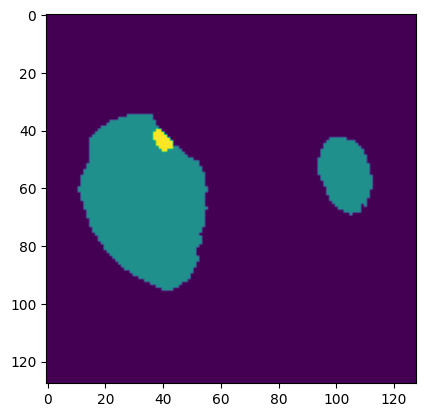

In [94]:
# Define a selective NII transformation function to extract specific slices for prediction
def nii_tfm_selctive(fn, wins, curr_slice):
    """
    Transform a specific slice from an NII file into a list of TensorImages.

    Parameters:
        - fn (str): Filepath of the NII file to be transformed.
        - wins (tuple): Windowing parameters specified as (width, level).
        - curr_slice (int): Index of the specific slice to be extracted and transformed.

    Returns:
        - list: A list containing TensorImages transformed from the specified slice of the NII file.
    """
    slices = []
    # Read the NII file and extract the specific slice indicated by 'curr_slice'
    test_nii = read_nii(fn)
    data = tensor(test_nii[..., curr_slice].astype(np.float32))
    # Apply windowing and scale pixel values to [0, 255]
    data = (data.to_nchan(wins) * 255).byte()
    slices.append(TensorImage(data))
    return slices

# Define a function to check if a contour is present in the image
def check(img):
    """
    Check if a contour is present in the input image.

    Parameters:
        - img (array): Input image represented as a NumPy array.

    Returns:
        - int: 1 if a contour is present, 0 otherwise.
    """
    cnt, h = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(cnt) > 0:
        return 1
    else:
        return 0

# Define lists containing sample numbers, corresponding volume names, and segmentation names
nums = [3, 4, 5]
vol_names = ['volume-100.nii', 'volume-102.nii', 'volume-102.nii']
seg_names = ['segmentation-100.nii', 'segmentation-102.nii', 'segmentation-102.nii']

# Initialize a confusion matrix to store prediction results
conf_matrix = np.zeros((2, 2), dtype=int)

# Iterate through samples, volume names, and segmentation names
for nums, vol_names, seg_names in zip(nums, vol_names, seg_names):
    curr_mask = read_nii(df_files.loc[nums, 'mask_dirname'] + "/" + df_files.loc[nums, 'mask_filename'])
    # Iterate through slices from 250 to 550 with a step of 10
    for curr_slice in tqdm(range(250, 550, 10)):
        # Transform the specific slice for prediction using the selective NII transformation function
        test_file = nii_tfm_selctive(df_files.loc[nums, 'dirname'] + "/" + df_files.loc[nums, 'filename'],
                                      [dicom_windows.liver, dicom_windows.custom], curr_slice)
        # Create a test dataloader for the transformed slice
        test_dl = learn0.dls.test_dl(test_file)
        # Get predictions and true labels for the test slice
        preds, y = learn0.get_preds(dl=test_dl)
        # Extract the predicted mask by selecting the class index with the highest probability
        predicted_mask = np.argmax(preds, axis=1)
        plt.imshow(predicted_mask[0])
        a = np.array(predicted_mask[0])

        # Initialize flags to indicate presence of classes in predicted and actual masks
        tumor_p, back_p, liver_p = False, False, False
        tumor_t, back_t, liver_t = False, False, False

        # Print the current slice index
        print('curr slice:', curr_slice)

        # Check if specific classes (0: background, 1: liver, 2: tumor) are present in the predicted mask
        unique = np.unique(a)
        print("predicted", unique)
        if 0 in unique:
            back_p = True
        if 1 in unique:
            liver_p = True
        if 2 in unique:
            tumor_p = True

        # Extract actual mask values for the current slice
        mask = Image.fromarray(curr_mask[..., curr_slice].astype('uint8'), mode="L")

        # Check if specific classes (0: background, 1: liver, 2: tumor) are present in the actual mask
        unique = np.unique(mask)
        print("actual:", unique)
        if 0 in unique:
            back_t = True
        if 1 in unique:
            liver_t = True
        if 2 in unique:
            tumor_t = True

        # Populate the confusion matrix based on presence of classes in predicted and actual masks
        if tumor_p and tumor_t:
            conf_matrix[0, 0] += 1
        if not tumor_p and not tumor_t:
            conf_matrix[1, 1] += 1
        if not tumor_p and tumor_t:
            conf_matrix[1, 0] += 1
        if tumor_p and not tumor_t:
            conf_matrix[0, 1] += 1

# Print the final confusion matrix
#print(conf_matrix)

# Explanation:
# - The code block defines functions to selectively transform NII slices and check for contours in images.
# - It iterates through specific slices of NII files for prediction and compares predicted and actual masks.
# - Flags are used to indicate presence of classes (background, liver, tumor) in predicted and actual masks.
# - Confusion matrix is populated based on the presence of classes, and the final matrix is printed.


# Plot Confusion Matrix

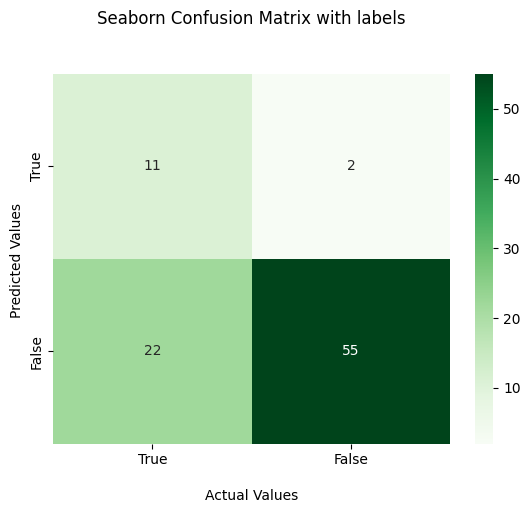

In [98]:
# Import seaborn library for creating a heatmap visualization of the confusion matrix
import seaborn as sns

# Create a heatmap visualization of the confusion matrix using seaborn
ax = sns.heatmap(conf_matrix, annot=True, cmap='Greens')

# Set the title of the heatmap
ax.set_title('Seaborn Confusion Matrix with labels\n\n')

# Set the labels for the x-axis (Actual Values) and y-axis (Predicted Values)
ax.set_xlabel('\nActual Values')
ax.set_ylabel('Predicted Values ')

# Define the tick labels for the x-axis and y-axis (True and False labels)
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['True', 'False'])

# Display the visualization of the Confusion Matrix using Matplotlib
plt.show()

# Explanation:
# - Seaborn's heatmap function is used to create a visual representation of the confusion matrix.
# - The 'conf_matrix' is passed as the data, 'annot=True' adds the numerical annotations to the heatmap cells,
#   and 'cmap='Blues'' sets the color map to shades of green.
# - The title of the heatmap is set to provide context about the visualization.
# - X-axis represents Actual Values, and Y-axis represents Predicted Values, as indicated by the axis labels.
# - The tick labels for x-axis and y-axis are set to display 'True' and 'False' corresponding to the classes in the confusion matrix.
# - The heatmap visualization is displayed using the 'plt.show()' function from Matplotlib.
